<a href="https://colab.research.google.com/github/shukurullo2004/Machine-learnings/blob/main/9_model_deployment_with_efficentb2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn

import torchvision
import requests
import os
from pathlib import Path
import zipfile

In [2]:
device = "cuda" if  torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
"FIRST OPTION"

# data_path = Path("data")
# image_path = data_path / "pizza_steak_sushi"
# data_path, image_path

# if image_path.is_dir():
#   print("path exists")
# else:
#   print("path does not exist, creating path ...")
#   image_path.mkdir(True, True)

# with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
#     request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
#     print("Downloading pizza, steak, sushi data...")
#     f.write(request.content)

# # Unzip pizza, steak, sushi data
# with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
#     print("Unzipping pizza, steak, sushi data...")
#     zip_ref.extractall(image_path)

# # Remove zip file
# os.remove(data_path / "pizza_steak_sushi.zip")

'FIRST OPTION'

In [4]:


!wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
zip_file = zipfile.ZipFile("pizza_steak_sushi.zip", "r")
zip_file.extractall()
zip_file.close()
 # !unzip pizza_steak_sushi.zip


--2024-03-19 22:13:04--  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip [following]
--2024-03-19 22:13:05--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15737296 (15M) [application/zip]
Saving to: ‘pizza_steak_sushi.zip’

pizza_steak_sushi.z 100%[===================>]  15.01M  91.9MB/s    in 0.2s    

2024-03-19 22:13:05 (91.9 MB/s) - ‘pizza_stea

In [5]:
os.remove("pizza_steak_sushi.zip")

In [6]:
test_dir = "test"
train_dir = "train"

In [7]:
def create_model():
  from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
  for param in model.parameters():
      param.requires_grad = False

  transform = weights.transforms()

  model.classifier = nn.Sequential(
    nn.Dropout(0.3, inplace = True),
    nn.Linear(1408, 3)

)
  return model, transform


In [8]:
model, transform = create_model()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 44.5MB/s]


In [9]:
transform

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
import torch
from torchvision import datasets, transforms

# Define transformations
my_transform = transforms.Compose([
    transforms.Resize((224,224)),  # Resize the image to 224x224
    transforms.ToTensor(),           # Convert the image to a tensor
    transforms.Normalize(            # Normalize the image
        mean=[0.485, 0.456, 0.406],   # Mean values for each channel
        std=[0.229, 0.224, 0.225]     # Standard deviations for each channel
    )
])

In [11]:
train_data = torchvision.datasets.ImageFolder(train_dir,
                                              transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir,
                                              transform=transform)

In [12]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size = 32,
                                               shuffle = True,
                                               )
test_dataloader = torch.utils.data.DataLoader(test_data,
                                               batch_size = 32,
                                               shuffle = False,
                                               )

In [14]:
img, label = next(iter(train_dataloader))
img.shape

torch.Size([32, 3, 288, 288])

In [15]:
!pip install torchinfo
import torchinfo
from torchinfo import summary
summary(model = model,
        input_size = (64,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width = 20
        )

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param #              Trainable
EfficientNet                                            [64, 3, 224, 224]    [64, 3]              --                   Partial
├─Sequential: 1-1                                       [64, 3, 224, 224]    [64, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation: 2-1                        [64, 3, 224, 224]    [64, 32, 112, 112]   --                   False
│    │    └─Conv2d: 3-1                                 [64, 3, 224, 224]    [64, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d: 3-2                            [64, 32, 112, 112]   [64, 32, 112, 112]   (64)                 False
│    │    └─SiLU: 3-3                                   [64, 32, 112, 112]   [64, 32, 112, 112]   --                   --
│    └─Sequential: 2-2                                  [64, 32, 112, 112]   [64, 16, 112, 112]   --                   Fal

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

step_size = 4  # Adjust learning rate every 10 epochs
gamma = 0.1  # Multiply learning rate by 0.1 every step_size epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)



In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 10
history = {
    "train_acc":[],
    "train_loss":[],
    "test_acc":[],
    "test_loss":[]
}
train_acc, train_loss = 0,0
for epoch in range(epochs):
    model.train()
    for batch,(X,y) in enumerate(train_dataloader):
        X,y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  # Update the model parameters

        _, predicted = torch.max(y_pred, 1)
        train_acc += (predicted == y).sum().item()
    # scheduler.step()

    train_acc = train_acc/len(train_dataloader.dataset)
    train_loss = train_loss/len(train_dataloader.dataset)
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)

    test_acc, test_loss =0, 0
    model.eval()
    with torch.no_grad():
      for X_val, y_val in test_dataloader:
          X_val,y_val = X_val.to(device), y_val.to(device)
          y_val_pred = model(X_val)

          loss = loss_fn(y_val_pred, y_val)
          test_loss += loss.item()

          _, predicted = torch.max(y_val_pred, 1)
          test_acc += (predicted == y_val).sum().item()

      test_loss /= len(test_dataloader.dataset)
      test_acc /= len(test_dataloader.dataset)
      history["test_acc"].append(test_acc)
      history["test_loss"].append(test_loss)

      print(f"Epochs: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")



Epochs: 1 | train_loss: 0.0378 | train_acc: 0.4756 | test_loss: 0.0365 | test_acc: 0.7733
Epochs: 2 | train_loss: 0.0302 | train_acc: 0.8421 | test_loss: 0.0331 | test_acc: 0.8800
Epochs: 3 | train_loss: 0.0267 | train_acc: 0.8215 | test_loss: 0.0308 | test_acc: 0.9067
Epochs: 4 | train_loss: 0.0257 | train_acc: 0.8570 | test_loss: 0.0268 | test_acc: 0.9200
Epochs: 5 | train_loss: 0.0227 | train_acc: 0.9194 | test_loss: 0.0264 | test_acc: 0.8933
Epochs: 6 | train_loss: 0.0202 | train_acc: 0.9330 | test_loss: 0.0240 | test_acc: 0.9333
Epochs: 7 | train_loss: 0.0180 | train_acc: 0.9241 | test_loss: 0.0233 | test_acc: 0.9333
Epochs: 8 | train_loss: 0.0198 | train_acc: 0.8886 | test_loss: 0.0232 | test_acc: 0.9067
Epochs: 9 | train_loss: 0.0189 | train_acc: 0.9239 | test_loss: 0.0218 | test_acc: 0.9200
Epochs: 10 | train_loss: 0.0167 | train_acc: 0.9641 | test_loss: 0.0190 | test_acc: 0.9200


In [18]:
model.eval()
test_acc1, test_loss1 = 0, 0
with torch.no_grad():
  for X,y in test_dataloader:
    X,y = X.to(device), y.to(device)
    test = model(X)
    _,test_pred = torch.max(test, 1)
    test_acc1 += (test_pred == y).sum().item()
    loss = loss_fn(test, y)
    test_loss1 += loss.item()

  test_loss1 /= len(test_dataloader.dataset)
  test_acc1 /= len(test_dataloader.dataset)



print(f"test acc: {test_acc1:.4f} || test loss: {test_loss1:.4f}")

test acc: 0.9200 || test loss: 0.0190


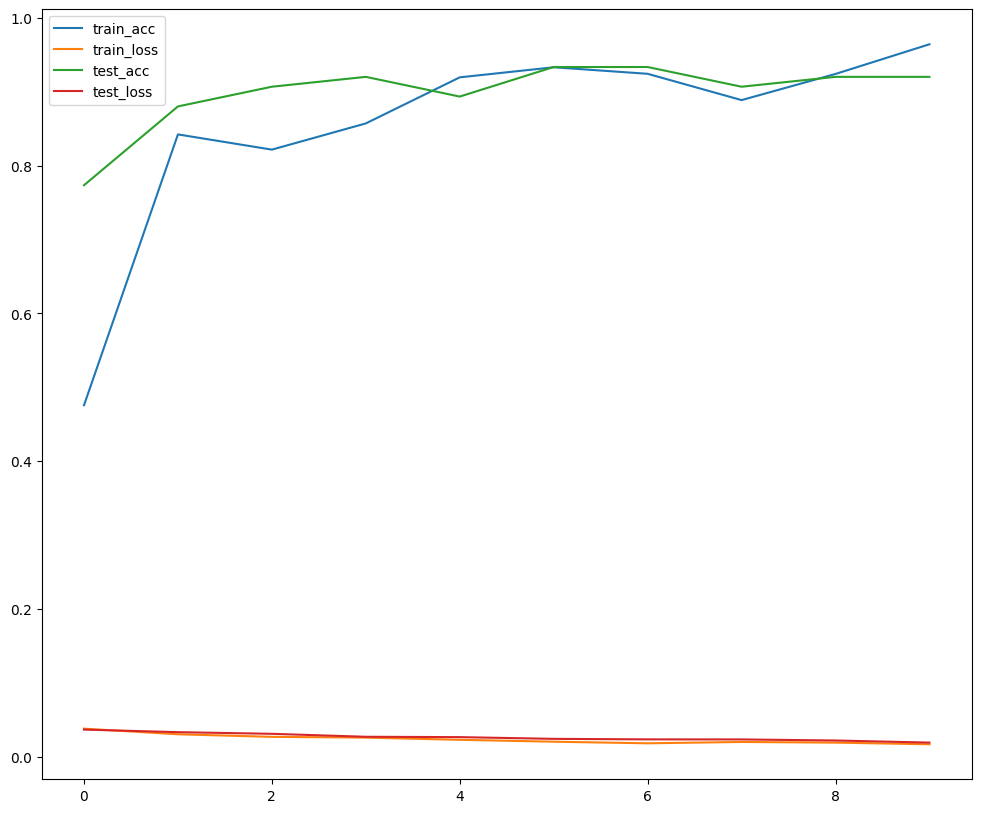

In [19]:
data = pd.DataFrame(history).plot(figsize = (12,10))

In [20]:
torch.save(model.state_dict(),"food_model.pth")

In [21]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("food_model.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [22]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in model.parameters())
effnetb2_total_params

7705221

In [23]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": history["test_loss"][-1],
                  "test_acc": history["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.018962042729059856,
 'test_acc': 0.92,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

In [24]:
def create_vit_model():
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  from torchvision.models import vit_b_16,ViT_B_16_Weights

  weigths = ViT_B_16_Weights.DEFAULT

  model = vit_b_16(weigths)

  transform = weigths.transforms()
  for params in model.parameters():
    params.requires_grad = False



  model.heads = nn.Sequential(
      nn.Dropout(0.3),
      nn.Linear(768,3),
  )

  return model, transform

In [31]:
vit_model, transform_vit = create_vit_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 153MB/s]


In [32]:
transform_vit

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_data_vit= torchvision.datasets.ImageFolder(
    train_dir,
    transform_vit
)
test_data_vit = torchvision.datasets.ImageFolder(
    test_dir,
    transform_vit
)

In [34]:
train_dataloader_vit = torch.utils.data.DataLoader(train_data_vit,
                                               batch_size = 32,
                                               shuffle = True,
                                               )
test_dataloader_vit = torch.utils.data.DataLoader(test_data_vit,
                                               batch_size = 32,
                                               shuffle = False,
                                               )

In [35]:
img,label = next(iter(train_dataloader))
img.shape

torch.Size([32, 3, 288, 288])

In [36]:
summary(vit_model,
        input_size = (32,3,224,224),
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20)

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Trainable
VisionTransformer                             [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d: 1-1                                 [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder: 1-2                                [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout: 2-1                           [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential: 2-2                        [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock: 3-3                 [32, 197, 768]       [32, 197, 

In [37]:
vit_model.to(device)
summary(vit_model,
        input_size = (32,3,224,224),
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20)

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Trainable
VisionTransformer                             [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d: 1-1                                 [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder: 1-2                                [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout: 2-1                           [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential: 2-2                        [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock: 3-3                 [32, 197, 768]       [32, 197, 

In [38]:
optimizer = torch.optim.Adam(params = vit_model.parameters(), lr = 0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 10
history_vit = {
    "train_accv":[],
    "train_lossv":[],
    "test_accv":[],
    "test_lossv":[]
}

best_acc = 0
current_model =0
train_accv, train_lossv = 0, 0
for epoch in range(epochs):
  vit_model.train()
  for batch, (X,y) in enumerate(train_dataloader_vit):
    X,y = X.to(device), y.to(device)
    y_pred = vit_model(X)
    loss = loss_fn(y_pred,y)
    train_lossv += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _,y_pred_class = torch.max(y_pred, 1)
    train_accv += (y_pred_class == y).sum().item()

  train_accv = train_accv/len(train_dataloader.dataset)
  train_lossv = train_lossv/len(train_dataloader.dataset)
  history_vit["train_accv"].append(train_accv)
  history_vit["train_lossv"].append(train_lossv)
  test_accv, test_lossv = 0, 0
  vit_model.eval()
  with torch.no_grad():
      for X_val, y_val in test_dataloader_vit:
        X_val,y_val = X_val.to(device), y_val.to(device)
        y_val_pred_vit = vit_model(X_val)
        loss_v = loss_fn(y_val_pred_vit, y_val)
        test_lossv += loss_v.item()

        _,predict_y = torch.max(y_val_pred_vit, 1)
        test_accv += (predict_y == y_val).sum().item()

      test_accv /= len(test_dataloader.dataset)
      test_lossv /= len(test_dataloader.dataset)
      history_vit["test_accv"].append(test_accv)
      history_vit["test_lossv"].append(test_lossv)
      if (test_accv > best_acc):
        best_acc = test_accv
        best_epoch = epoch
        torch.save(vit_model.state_dict(), 'best_model.pt')
        print(f"Best model found at epoch: {best_epoch + 1}, acc: {best_acc}")
      else:
        print("")

  print(f"Epochs: {epoch+1} | train_loss: {train_lossv:.4f} | train_acc: {train_accv:.4f} | test_loss: {test_lossv:.4f} | test_acc: {test_accv:.4f}")

Best model found at epoch: 1, acc: 0.88
Epochs: 1 | train_loss: 0.0260 | train_acc: 0.6889 | test_loss: 0.0199 | test_acc: 0.8800
Best model found at epoch: 2, acc: 0.92
Epochs: 2 | train_loss: 0.0131 | train_acc: 0.9275 | test_loss: 0.0124 | test_acc: 0.9200
Best model found at epoch: 3, acc: 0.9333333333333333
Epochs: 3 | train_loss: 0.0071 | train_acc: 0.9686 | test_loss: 0.0105 | test_acc: 0.9333
Best model found at epoch: 4, acc: 0.9466666666666667
Epochs: 4 | train_loss: 0.0056 | train_acc: 0.9687 | test_loss: 0.0092 | test_acc: 0.9467

Epochs: 5 | train_loss: 0.0049 | train_acc: 0.9732 | test_loss: 0.0086 | test_acc: 0.9467
Best model found at epoch: 6, acc: 0.96
Epochs: 6 | train_loss: 0.0054 | train_acc: 0.9777 | test_loss: 0.0082 | test_acc: 0.9600

Epochs: 7 | train_loss: 0.0038 | train_acc: 0.9777 | test_loss: 0.0095 | test_acc: 0.9333

Epochs: 8 | train_loss: 0.0031 | train_acc: 0.9866 | test_loss: 0.0090 | test_acc: 0.9333

Epochs: 9 | train_loss: 0.0040 | train_acc: 0.98

In [40]:
test_accv, test_lossv = 0, 0
vit_model.eval()
with torch.no_grad():
      for X_val, y_val in test_dataloader_vit:
        X_val,y_val = X_val.to(device), y_val.to(device)
        y_val_pred_vit = vit_model(X_val)
        loss_v = loss_fn(y_val_pred_vit, y_val)
        test_lossv += loss_v.item()

        _,predict_y = torch.max(y_val_pred_vit, 1)
        test_accv += (predict_y == y_val).sum().item()

      test_accv = test_accv/len(test_dataloader.dataset)
      test_lossv /= len(test_dataloader.dataset)
      print(f"Epochs: {epoch+1} | test_loss: {test_lossv:.4f} | test_acc: {test_accv:.4f}")

Epochs: 10 | test_loss: 0.0068 | test_acc: 0.9200


<Axes: >

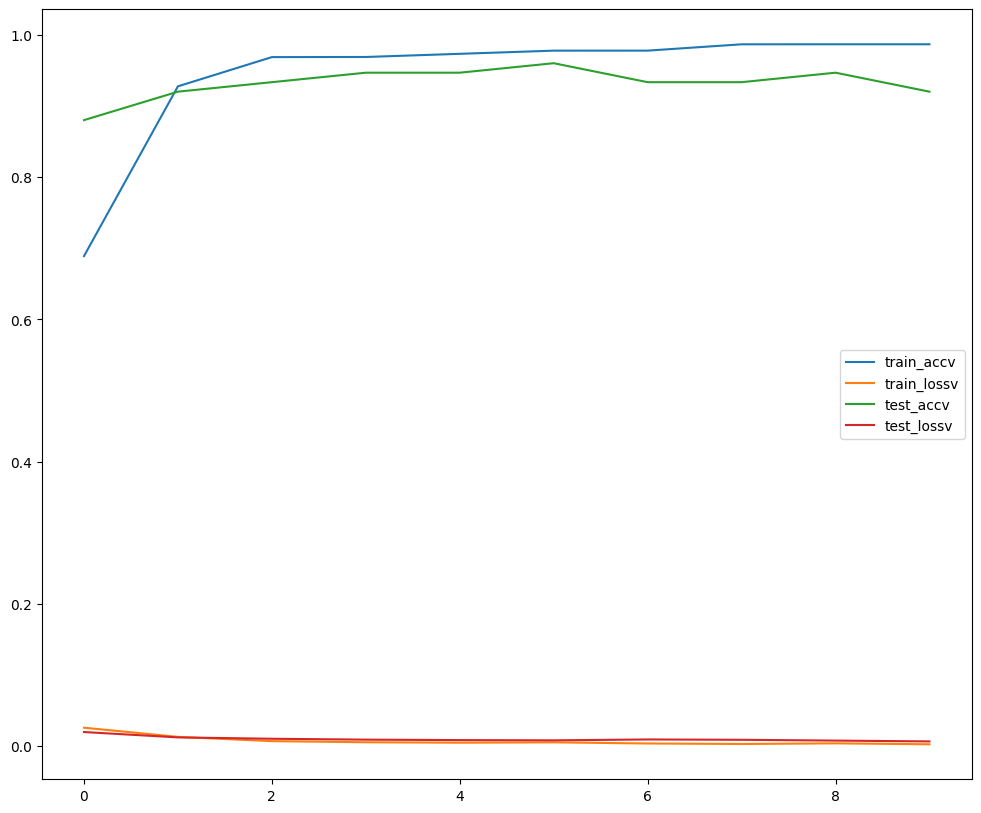

In [41]:
data = pd.DataFrame(history_vit).plot(figsize= (12,10))
data

In [42]:
# torch.save(vit_model.state_dict(),"food_model_vit.pth")

In [43]:
from pathlib import Path

vit_model_size = Path("best_model.pt").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained vit_16 feature extractor model size: {vit_model_size} MB")

Pretrained vit_16 feature extractor model size: 327 MB


In [44]:
# Count number of parameters in EffNetB2
vit_total_params = sum(torch.numel(param) for param in vit_model.parameters())
vit_total_params

85800963

In [45]:
# Create a dictionary with EffNetB2 statistics
vit_stats = {"test_lossv": history_vit["test_lossv"][5],
                  "test_accv": history_vit["test_accv"][5],
                  "number_of_parameters": vit_total_params,
                  "model_size (MB)": vit_model_size}
vit_stats

{'test_lossv': 0.00824116716782252,
 'test_accv': 0.96,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [46]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: test


[PosixPath('test/sushi/1172255.jpg'),
 PosixPath('test/sushi/988559.jpg'),
 PosixPath('test/sushi/858157.jpg'),
 PosixPath('test/sushi/684266.jpg'),
 PosixPath('test/sushi/343036.jpg')]

In [47]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

In [48]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=model,
                                          transform=transform,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/75 [00:00<?, ?it/s]

In [49]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:1]

[{'image_path': PosixPath('test/sushi/1172255.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.6819,
  'pred_class': 'sushi',
  'time_for_pred': 0.1137,
  'correct': True}]

In [50]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,test/sushi/1172255.jpg,sushi,0.6819,sushi,0.1137,True
1,test/sushi/988559.jpg,sushi,0.6569,sushi,0.1036,True
2,test/sushi/858157.jpg,sushi,0.4023,sushi,0.1153,True
3,test/sushi/684266.jpg,sushi,0.4379,steak,0.1051,False
4,test/sushi/343036.jpg,sushi,0.5562,sushi,0.0994,True


In [51]:
# Make predictions across test dataset with EffNetB2
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=vit_model,
                                          transform=transform_vit,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/75 [00:00<?, ?it/s]

In [52]:
import pandas as pd
vit_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
vit_test_pred_df.head(5)

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,test/sushi/1172255.jpg,sushi,0.6819,sushi,0.1137,True
1,test/sushi/988559.jpg,sushi,0.6569,sushi,0.1036,True
2,test/sushi/858157.jpg,sushi,0.4023,sushi,0.1153,True
3,test/sushi/684266.jpg,sushi,0.4379,steak,0.1051,False
4,test/sushi/343036.jpg,sushi,0.5562,sushi,0.0994,True


In [53]:
effnetb2_test_pred_df.correct.value_counts()

True     69
False     6
Name: correct, dtype: int64

In [54]:
vit_test_pred_df.correct.value_counts()

True     69
False     6
Name: correct, dtype: int64

In [55]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),test_lossv,test_accv,model
0,0.018962,92.0,7705221,29,NaN,NaN,EffNetB2
1,NaN,NaN,85800963,327,0.008241,0.96,ViT


In [56]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),test_lossv,test_accv
ViT to EffNetB2 ratios,NaN,NaN,11.135432,11.275862,NaN,NaN


In [57]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 11.2 MB/s eta 0:00:00
Gradio version: 4.22.0


In [58]:
# Put EffNetB2 on CPU
model.to("cpu")

# Check the device
next(iter(model.parameters())).device

device(type='cpu')

In [59]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = transform(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    model.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(model(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [60]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: test/sushi/2190404.jpg

Prediction label and probability dictionary: 
{'pizza': 0.16938962042331696, 'steak': 0.13014093041419983, 'sushi': 0.7004694938659668}
Prediction time: 0.09848 seconds


In [61]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['test/sushi/2190404.jpg'],
 ['test/steak/1868005.jpg'],
 ['test/sushi/3806282.jpg']]

In [62]:
import gradio as gr

# Create title, description and article strings
title = "Shukurullo FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created by Shukurullo Meliboev at [09. PyTorch Model Deployment]"

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5aabc80bcb1cb1c54a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [63]:
# demos/
# └── foodvision_mini/
#     ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
#     ├── app.py
#     ├── examples/
#     │   ├── example_1.jpg
#     │   ├── example_2.jpg
#     │   └── example_3.jpg
#     ├── model.py
#     └── requirements.txt

In [64]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)

# Check what's in the folder
!ls demos/foodvision_mini/

In [65]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('test/sushi/2190404.jpg'),
                            Path('test/pizza/971934.jpg'),
                            Path('test/sushi/1245193.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying test/sushi/2190404.jpg to demos/foodvision_mini/examples/2190404.jpg
[INFO] Copying test/pizza/971934.jpg to demos/foodvision_mini/examples/971934.jpg
[INFO] Copying test/sushi/1245193.jpg to demos/foodvision_mini/examples/1245193.jpg


In [66]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/971934.jpg'], ['examples/1245193.jpg'], ['examples/2190404.jpg']]

In [67]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "food_model.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move food_model.pth to demos/foodvision_mini/food_model.pth
[INFO] Model move complete.


In [68]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


In [71]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# import gradio as gr

# Create title, description and article strings
title = "Shukurullo FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created by Shukurullo Meliboev at [09. PyTorch Model Deployment]"

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False)

Overwriting demos/foodvision_mini/app.py


In [72]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Overwriting demos/foodvision_mini/requirements.txt


In [73]:
!ls demos/foodvision_mini


app.py	examples  food_model.pth  model.py  requirements.txt


In [77]:
# zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"


In [76]:
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 56%)
  adding: examples/ (stored 0%)
  adding: examples/971934.jpg (deflated 0%)
  adding: examples/1245193.jpg (deflated 4%)
  adding: examples/2190404.jpg (deflated 0%)
  adding: food_model.pth (deflated 8%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 4%)


In [78]:
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>